# Churn Prediction Modelling

#### Imports


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
import heapq

### Load  Dataset


In [3]:
file_path = 'Dataset\\Telco-Customer-Churn.csv'
churn_data = pd.read_csv(file_path)

## Data PreProcessing

### Clean the data using what we learned from EDA


#### Drop customerID

In [4]:
churn_data = churn_data.drop(['customerID'],axis = 1) 
churn_data.head()   

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


#### Convert total charges from object into float

In [5]:
# Replace empty strings with NaN
churn_data['TotalCharges'] = churn_data['TotalCharges'].replace(" ", np.nan)

# Converts from object to float data type
churn_data['TotalCharges'] = churn_data['TotalCharges'].astype(float)

##### Deal with missing Data

- From our EDA we had 11 rows of missing data for Total charges 

In [6]:
churn_data[np.isnan(churn_data['TotalCharges'])]

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3331,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3826,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4380,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
5218,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
6670,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No


- we compute TotalCharges: TotalCharges = Tenure * Montlycharge 

In [7]:
def compute_total_charges(row):
    if pd.isnull(row['TotalCharges']) and row['MonthlyCharges'] > 0:
        return row['tenure'] * row['MonthlyCharges']
    return row['TotalCharges']

churn_data['TotalCharges'] = churn_data.apply(compute_total_charges, axis=1)


In [8]:
churn_data[np.isnan(churn_data['TotalCharges'])]

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn


We have now dealt with NaN rows and can proceeed.

### Encoding Categorical Variables.

In [9]:
# Identify all categorical columns by data type
categorical_cols_all = churn_data.select_dtypes(include=['object']).columns
print("All categorical columns:", categorical_cols_all)


All categorical columns: Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'Churn'],
      dtype='object')


- Split the Categorical Variables into Binary and non-Binary

In [10]:
# Binary columns  have only 2 possible values.
binary_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']

non_binary_cols = ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
                   'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
                   'Contract', 'PaymentMethod']


Encode Binary and Non-Binary Categorical Variables

In [11]:
binary_mappings = {}
one_hot_categories = {}

for col in binary_cols:
    # Get unique values
    unique_values = churn_data[col].unique()
    #store the mapping
    mapping = {unique_values[0]: 0, unique_values[1]: 1}
    binary_mappings[col] = mapping
    # Map the first unique value to 0 and the second to 1
    churn_data[col] = churn_data[col].apply(lambda x: 0 if x == unique_values[0] else 1)
    
    
for col in non_binary_cols:
    # Get unique categories for each column
    unique_values = churn_data[col].unique()
    one_hot_categories[col] = churn_data[col].unique().tolist()
    for value in unique_values:
        # Create a new column for each unique category
        churn_data[f"{col}_{value}"] = (churn_data[col] == value).astype(int)
    # Drop the original non-binary categorical column
    churn_data.drop(col, axis=1, inplace=True)

# Check the transformed dataset
churn_data.head()


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,...,StreamingMovies_No,StreamingMovies_Yes,StreamingMovies_No internet service,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Electronic check,PaymentMethod_Mailed check,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic)
0,0,0,0,0,1,0,0,29.85,29.85,0,...,1,0,0,1,0,0,1,0,0,0
1,1,0,1,0,34,1,1,56.95,1889.50,0,...,1,0,0,0,1,0,0,1,0,0
2,1,0,1,0,2,1,0,53.85,108.15,1,...,1,0,0,1,0,0,0,1,0,0
3,1,0,1,0,45,0,1,42.30,1840.75,0,...,1,0,0,0,1,0,0,0,1,0
4,0,0,1,0,2,1,0,70.70,151.65,1,...,1,0,0,1,0,0,1,0,0,0


## Normalising the Data

In [12]:
#Min_Max Normalisation
min_max_data = churn_data.copy()
for col in ['tenure', 'MonthlyCharges', 'TotalCharges']:
    min_value = min_max_data[col].min()
    max_value = min_max_data[col].max()
    min_max_data[col] = (min_max_data[col] - min_value) / (max_value - min_value)
    
z_score_data = churn_data.copy()
for col in ['tenure', 'MonthlyCharges', 'TotalCharges']:
    mean = z_score_data[col].mean()
    std = z_score_data[col].std()
    z_score_data[col] = (z_score_data[col]-mean)/std
    


Min Max Normalisation:

In [13]:
min_max_data.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,...,StreamingMovies_No,StreamingMovies_Yes,StreamingMovies_No internet service,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Electronic check,PaymentMethod_Mailed check,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic)
0,0,0,0,0,0.013889,0,0,0.115423,0.003437,0,...,1,0,0,1,0,0,1,0,0,0
1,1,0,1,0,0.472222,1,1,0.385075,0.217564,0,...,1,0,0,0,1,0,0,1,0,0
2,1,0,1,0,0.027778,1,0,0.354229,0.012453,1,...,1,0,0,1,0,0,0,1,0,0
3,1,0,1,0,0.625000,0,1,0.239303,0.211951,0,...,1,0,0,0,1,0,0,0,1,0
4,0,0,1,0,0.027778,1,0,0.521891,0.017462,1,...,1,0,0,1,0,0,1,0,0,0


Z-score Normalisation

In [14]:
z_score_data.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,...,StreamingMovies_No,StreamingMovies_Yes,StreamingMovies_No internet service,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Electronic check,PaymentMethod_Mailed check,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic)
0,0,0,0,0,-1.277354,0,0,-1.160241,-0.992540,0,...,1,0,0,1,0,0,1,0,0,0
1,1,0,1,0,0.066323,1,1,-0.259611,-0.172152,0,...,1,0,0,0,1,0,0,1,0,0
2,1,0,1,0,-1.236636,1,0,-0.362635,-0.957998,1,...,1,0,0,1,0,0,0,1,0,0
3,1,0,1,0,0.514215,0,1,-0.746482,-0.193659,0,...,1,0,0,0,1,0,0,0,1,0
4,0,0,1,0,-1.236636,1,0,0.197351,-0.938808,1,...,1,0,0,1,0,0,1,0,0,0


## Splitting Dataset

In [15]:
def train_test_split(X, y, test_size=0.2, random_seed=2024):
    np.random.seed(random_seed)  # For reproducibility
    indices = np.random.permutation(len(X))  # Shuffle the indices
    test_set_size = int(len(X) * test_size)
    
    test_indices = indices[:test_set_size]
    train_indices = indices[test_set_size:]
    
    X_train, X_test = X[train_indices], X[test_indices]
    y_train, y_test = y[train_indices], y[test_indices]
    
    return X_train, X_test, y_train, y_test


## K-Nearest-Neighbour Model

In [16]:
class NearestNeighbours:
    
    def __init__(self,neighbours=1):
        
        if neighbours < 1:
            self.n_neighbours = 1
        else:
            self.n_neighbours = neighbours
            
    
    def get_Num_Neighbours(self):
        return self.n_neighbours
    
    def fit(self,X_train,y_train):
        self.X_train = X_train
        self.y_train = y_train
        
    
    def euclidean_distance(self,p1,p2):
        return np.sqrt(np.sum((np.array(p1) - np.array(p2)) ** 2))
    

    # def insertion_sort(self, distances): # used when neighbours > 1
    #     for i in range(1, len(distances)):
    #         current_distance = distances[i]
    #         j = i - 1
    #         while j >= 0 and distances[j][0] > current_distance[0]:
    #             distances[j + 1] = distances[j]
    #             j -= 1
    #         distances[j + 1] = current_distance
    #     return distances


    def find_closest_neighbor(self, test_sample): # used when number of neighbours is 1
        min_distance = float('inf')  
        closest_label = None
        dist_cl =[]

        for i in range(len(self.X_train)):
            X_train = self.X_train[i]
            y_train = self.y_train[i]
            dist = self.euclidean_distance(X_train, test_sample)

            # Update minimum distance and corresponding label if a closer neighbor is found
            if dist < min_distance:
                min_distance = dist
                closest_label = y_train
        dist_cl.append((min_distance,closest_label))
        return  dist_cl
    
    

    def get_nearest_neighbour(self, test_sample):
        # Determine the effective value of k
        k = min(self.n_neighbours, len(self.X_train))

        # Calculate all distances without sorting
        distances = [
            (self.euclidean_distance(train_sample, test_sample), label)
            for train_sample, label in zip(self.X_train, self.y_train)
        ]

        # Use heapq to get the k smallest distances directly
        k_nearest_neighbours = heapq.nsmallest(k, distances, key=lambda x: x[0])
        return k_nearest_neighbours



    def vote_label(self,distances): #vote label by returning label with the most counts.
        labels = []
        for distance,label in distances:
            labels.append(label)
            
        unique_label,counts = np.unique(labels,return_counts=True)
        index = np.argmax(counts)
        return unique_label[index] # if there is a tie it would return the first label encountered.

    def predict(self, X_test):
        predictions = []

        for i in X_test:
            nearest_neighbours = self.get_nearest_neighbour(i)
            label = self.vote_label(nearest_neighbours)
            predictions.append(label)
            
    
        return predictions
    
    
    def score(self,predictions,y_test):
        error_rate = 1 -np.mean(predictions == y_test)
        num_errors = np.size(predictions) - np.count_nonzero(predictions == y_test)
        print("Error rate is: " + str(error_rate))
        print("Number of errors: " + str(num_errors) + " out of " + str(len(y_test)) )
        
    def error_rate(self,predictions,y_test):
        error_rate = 1 -np.mean(predictions == y_test)
        return error_rate

In [17]:
X = min_max_data.drop(columns=['Churn']) 
y = min_max_data['Churn'] 

# Split data
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.2, random_seed=42)

# Instantiate and train KNN model
knn_model = NearestNeighbours(neighbours=20)
knn_model.fit(X_train, y_train)

# Predict on test data
predictions = knn_model.predict(X_test)

# Evaluate model
knn_model.score(predictions, y_test)


Error rate is: 0.20667613636363635
Number of errors: 291 out of 1408


In [ ]:
X = z_score_data.drop(columns=['Churn']) 
y = z_score_data['Churn'] 

# Split data
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.2, random_seed=42)

# Instantiate and train KNN model
knn_model = NearestNeighbours(neighbours=20)
knn_model.fit(X_train, y_train)

# Predict on test data
predictions = knn_model.predict(X_test)

# Evaluate model
knn_model.score(predictions, y_test)

Error rate is: 0.19034090909090906
Number of errors: 268 out of 1408


### Investigating the Best K value FOR K-NN

In [ ]:
def find_best_k(train_features, train_labels, test_features, test_labels, max_k=100):
    results = np.zeros(max_k)  # Array to store error rates for each k
    
    for k in range(1, max_k + 1):
        knn = NearestNeighbours(k)  # Initialise KNN model with k neighbours
        knn.fit(train_features, train_labels)  # Fit the model on training data
        predictions = knn.predict(test_features) 
        error_rate = knn.error_rate(predictions, test_labels)  
        results[k - 1] = error_rate  # Store the error rate at the (k-1) index
    
    return results

def plot_error_rates(error_rates):
    # Generate a range of k values from 1 to the length of error_rates
    k_values = range(1, len(error_rates) + 1)
    
    # Plot error rates for each k
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, error_rates, marker='o', linestyle='-', color='b')
    plt.title("Error Rate for Different k Values in KNN")
    plt.xlabel("k")
    plt.ylabel("Error Rate")
    plt.show()


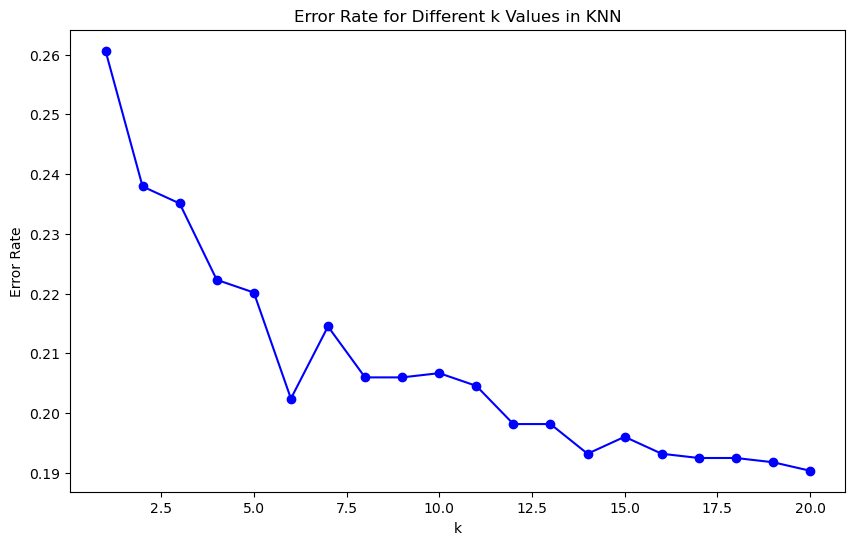

Best k: 20 with error rate: 0.19034090909090906


In [ ]:
#Test different values of k and get error rates
error_rates = find_best_k(X_train, y_train, X_test, y_test, max_k=20)

plot_error_rates(error_rates)

best_k = np.argmin(error_rates) + 1  # Adding 1 to convert index to k-value
print(f"Best k: {best_k} with error rate: {error_rates[best_k - 1]}")
